In [1]:
import torch
from torch import nn, autograd as ag
import matplotlib.pyplot as plt
import numpy as np
import pyccl as ccl
import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

In [2]:
n_samples = 50

Omega_b_arr = np.linspace(0.04, 0.06, n_samples)
Omega_c_arr = np.linspace(0.25, 0.35, n_samples)
h_arr = np.linspace(0.6, 0.8, n_samples)
sigma8_arr = np.linspace(0.7, 0.9, n_samples)
n_s_arr = np.linspace(0.9, 1.1, n_samples)

z= np.linspace(0., 3., 256)
z0 = 0.1
dndz = 1./(2.*z0) * (z / z0)**2 * np.exp(-z/z0)

l_arr = np.unique(np.geomspace(2, 4000, 30).astype(int))

if os.path.isfile('Cgg_data.npz'):
    data = np.load('Cgg_data.npz')
    Cgg_data = data['Cgg_data']
    l_arr = data['l_arr']
    Omega_b_arr = data['Omega_b_arr']
    Omega_c_arr = data['Omega_c_arr']
    h_arr = data['h_arr']
    sigma8_arr = data['sigma8_arr']
    n_s_arr = data['n_s_arr']
else:
    Cgg_data = np.zeros((n_samples, len(l_arr)))
    for i in tqdm.trange(n_samples):
        cosmo = ccl.Cosmology(Omega_c=Omega_c_arr[i], Omega_b=Omega_b_arr[i],
                            h=h_arr[i], sigma8=sigma8_arr[i], n_s=n_s_arr[i])
        lensTracer = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz))
        Cgg_data[i,:] = ccl.angular_cl(cosmo, lensTracer, lensTracer, l_arr)
        plt.loglog(l_arr, Cgg_data[i,:])

    np.savez('Cgg_data.npz', Cgg_data=Cgg_data, l_arr=l_arr, Omega_b_arr=Omega_b_arr,
                Omega_c_arr=Omega_c_arr, h_arr=h_arr, sigma8_arr=sigma8_arr, n_s_arr=n_s_arr)

In [3]:
model = nn.Sequential(
    nn.Linear(5, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, len(l_arr))
)
    
# collate training data
X = np.vstack((Omega_b_arr, Omega_c_arr, h_arr, sigma8_arr, n_s_arr)).T
print(X.shape)
y = Cgg_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# standardize data
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)

# create dataloader
batch_size = 512

# define loss function
loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# train model
n_epochs = 100
train_losses = []
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        train_loss += loss.item()
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {train_loss:.4f}')


(50, 5)
Epoch 1/100, Loss: 0.9929
Epoch 2/100, Loss: 0.8331
Epoch 3/100, Loss: 0.6486
Epoch 4/100, Loss: 0.4148
Epoch 5/100, Loss: 0.1742
Epoch 6/100, Loss: 0.0477
Epoch 7/100, Loss: 0.1486
Epoch 8/100, Loss: 0.2036
Epoch 9/100, Loss: 0.1118
Epoch 10/100, Loss: 0.0251
Epoch 11/100, Loss: 0.0203
Epoch 12/100, Loss: 0.0627
Epoch 13/100, Loss: 0.0900
Epoch 14/100, Loss: 0.0883
Epoch 15/100, Loss: 0.0661
Epoch 16/100, Loss: 0.0375
Epoch 17/100, Loss: 0.0163
Epoch 18/100, Loss: 0.0110
Epoch 19/100, Loss: 0.0198
Epoch 20/100, Loss: 0.0308
Epoch 21/100, Loss: 0.0321
Epoch 22/100, Loss: 0.0225
Epoch 23/100, Loss: 0.0113
Epoch 24/100, Loss: 0.0073
Epoch 25/100, Loss: 0.0110
Epoch 26/100, Loss: 0.0160
Epoch 27/100, Loss: 0.0169
Epoch 28/100, Loss: 0.0135
Epoch 29/100, Loss: 0.0083
Epoch 30/100, Loss: 0.0048
Epoch 31/100, Loss: 0.0047
Epoch 32/100, Loss: 0.0067
Epoch 33/100, Loss: 0.0080
Epoch 34/100, Loss: 0.0070
Epoch 35/100, Loss: 0.0047
Epoch 36/100, Loss: 0.0031
Epoch 37/100, Loss: 0.0031
Ep

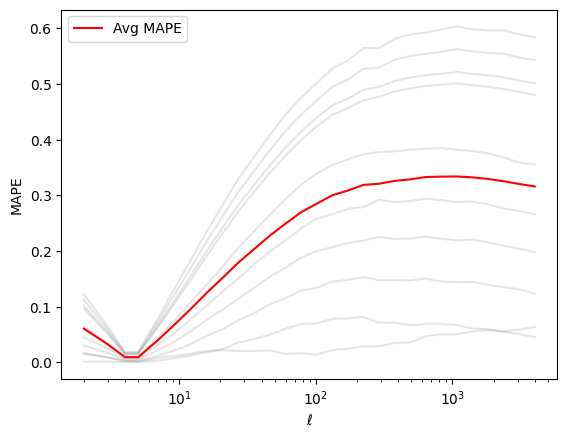

In [5]:
# evaluate model
preds = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
preds = scaler_y.inverse_transform(preds)
y_test = scaler_y.inverse_transform(y_test)

# compute mean absolute percentage error
mape = np.mean(np.abs(preds - y_test) / y_test) * 100

# plot mape for all samples along with avg
for i in range(len(y_test)):
    plt.plot(l_arr, np.abs(preds[i] - y_test[i]) / y_test[i], 'k', alpha=0.1)
plt.plot(l_arr, np.mean(np.abs(preds - y_test) / y_test, axis=0), 'r', label='Avg MAPE')
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel('MAPE')
plt.legend()

Text(0, 0.5, 'Loss')

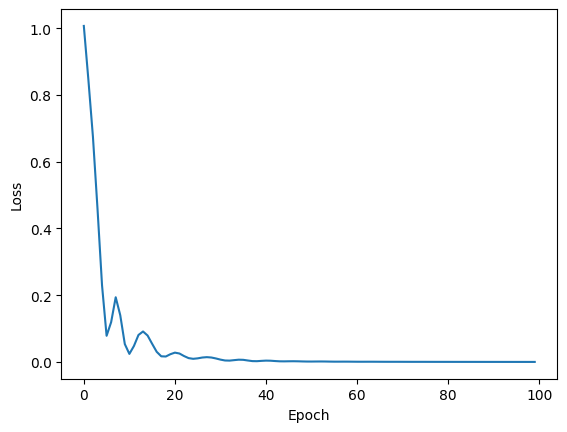

In [6]:
# plot training loss
plt.figure()
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
